In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.odr as odr
import icartt
import utilities

In [2]:
def SAE_fit_one_measurement( wavelength, SAE_fit, SAE_constant):
    return  SAE_constant*np.power(wavelength, -SAE_fit)

def AAE_fit_one_measurement( wavelength, AAE_fit, AAE_constant):
    return  AAE_constant*np.power(wavelength, -AAE_fit)

In [3]:
def SAE_power_fit(bscat_wvl_red,bscat_wvl_green,bscat_wvl_blue,w1,w2,w3,w_global_1,w_global_2,w_global_3):

    if(w1 <= 0 and w2 <= 0 and w3 <= 0):
        print("WARNING: wavelength <= 0")

    wavelength_instrument=np.array([w1,w2,w3])  # modify if necessary

    temp_SAE = np.nan; temp_SAE_constant = np.nan
    temp_sigma = np.nan; temp_sigma_constant = np.nan  #uncertainty of fit parameters

    SAE_three_lambda = np.empty(len(bscat_wvl_red)); SAE_constant = np.empty(len(bscat_wvl_red))
    sigma_SAE = np.empty(len(bscat_wvl_red)); sigma_constant = np.empty(len(bscat_wvl_red))

    #hide invalid values
    mask_red = bscat_wvl_red.mask(bscat_wvl_red == 0)
    mask_green = bscat_wvl_green.mask(bscat_wvl_green == 0)
    mask_blue = bscat_wvl_blue.mask(bscat_wvl_blue == 0)

    mask_RG = (mask_red/mask_green).mask((mask_red/mask_green == 1))
    mask_RG = mask_RG.mask((mask_red/mask_green) < 0)

    mask_RB = (mask_red/mask_blue).mask((mask_red/mask_blue) == 1)
    mask_RB = mask_RB.mask((mask_red/mask_blue) < 0)

    mask_GB = (mask_green/mask_blue).mask((mask_green/mask_blue) == 1)
    mask_GB = mask_GB.mask((mask_green/mask_blue) < 0)

    #compute SAE_two_lambda, which are used later when initializing SAE_three_lambda
    SAE_R_G = -np.log(mask_RG)/np.log(wavelength_instrument[0]/wavelength_instrument[1])
    SAE_R_B = -np.log(mask_RB)/np.log(wavelength_instrument[0]/wavelength_instrument[2])
    SAE_G_B = -np.log(mask_GB)/np.log(wavelength_instrument[1]/wavelength_instrument[2])

    W_coef = np.zeros(np.size((SAE_G_B.values)))
    w_sigma = np.zeros(np.size((SAE_G_B.values)))

    for m in range(len(bscat_wvl_red)):
            if (np.isnan(bscat_wvl_red[m])==0 and np.isnan(bscat_wvl_green[m])==0 and np.isnan(bscat_wvl_blue[m])==0):

                one_babs_at_three_lambda=[bscat_wvl_red[m],bscat_wvl_green[m],bscat_wvl_blue[m]]
                
                #use SAE_G_B as initial input 
                if((np.power(wavelength_instrument[1], -SAE_G_B.values[m])) > 0):
                    W_coef = np.array([SAE_G_B.values[m], bscat_wvl_green[m]/ (np.power(wavelength_instrument[1], -SAE_G_B.values[m]))] )
                    try:
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass
                temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                #use SAE_R_G as initial input
                if(((np.power(wavelength_instrument[0], -SAE_R_G.values[m]))) > 0 ):
                    W_coef = np.array([SAE_R_G.values[m], bscat_wvl_red[m]/ (np.power(wavelength_instrument[0], -SAE_R_G.values[m]))]  ) 
                    try:          
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass    #do not replace the previous results

                #make sure w_sigma exists
                if(w_sigma[0] != -1):
                    #check if the current inital guess (SAE_R_G) is better than the previous one (SAE_G_B): ? w_sigma is smaller
                    if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                
                        temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                    else:
                        pass       #do not replace the previous results
            
                #use SAE_R_B as initial input
                if((np.power(wavelength_instrument[2], -SAE_R_B.values[m])) > 0):
                    W_coef = np.array([SAE_R_B.values[m],bscat_wvl_blue[m]/ (np.power(wavelength_instrument[2], -SAE_R_B.values[m]))])
                    try:   
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass
                #make sure w_sigma exists
                if(w_sigma[0] != -1):               
                    #check if the current initial guess (SAE_R_B) is better than the previous one (SAE_G_B or SAE_R_G): ? w_sigma is smaller
                    if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                        
                        temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                    else: 
                        pass #do not replace the previous results   
            
            #Output the results
            SAE_three_lambda[m]=temp_SAE; SAE_constant[m]=temp_SAE_constant
            sigma_SAE[m]=temp_sigma; sigma_constant[m]=temp_sigma_constant
            #clear temp_variables
            temp_SAE=np.nan;temp_SAE_constant=np.nan
            temp_sigma=np.nan;temp_sigma_constant=np.nan

    b_scat_red=SAE_constant*(np.power(w_global_1, -SAE_three_lambda))
    b_scat_green=SAE_constant*(np.power(w_global_2, -SAE_three_lambda))
    b_scat_blue=SAE_constant*(np.power(w_global_3, -SAE_three_lambda))

    file_M_3_Bscat = pd.DataFrame() 
    file_M_3_Bscat['SAE'] = SAE_three_lambda; 
    file_M_3_Bscat['b_scat_red'] = b_scat_red ;file_M_3_Bscat['b_scat_green'] = b_scat_green; file_M_3_Bscat['b_scat_blue'] = b_scat_blue ; 

    return file_M_3_Bscat

In [4]:
def SAE_power_fit_2(bscat_wvl_red,bscat_wvl_green,bscat_wvl_blue,w1,w2,w3,w_global_1,w_global_2,w_global_3):

    if(w1 <= 0 and w2 <= 0 and w3 <= 0):
        print("WARNING: wavelength <= 0")

    wavelength_instrument=np.array([w1,w2,w3])  # modify if necessary

    temp_SAE = np.nan; temp_SAE_constant = np.nan
    temp_sigma = np.nan; temp_sigma_constant = np.nan  #uncertainty of fit parameters

    SAE_three_lambda = np.empty(len(bscat_wvl_red)); SAE_constant = np.empty(len(bscat_wvl_red))
    sigma_SAE = np.empty(len(bscat_wvl_red)); sigma_constant = np.empty(len(bscat_wvl_red))

    #compute SAE_two_lambda, which are used later when initializing SAE_three_lambda
    SAE_R_G = -np.log(bscat_wvl_red/bscat_wvl_green)/np.log(wavelength_instrument[0]/wavelength_instrument[1])
    SAE_R_B = -np.log(bscat_wvl_red/bscat_wvl_blue)/np.log(wavelength_instrument[0]/wavelength_instrument[2])
    SAE_G_B = -np.log(bscat_wvl_green/bscat_wvl_blue)/np.log(wavelength_instrument[1]/wavelength_instrument[2])

    W_coef = np.zeros(np.size((SAE_G_B.values)))
    w_sigma = np.zeros(np.size((SAE_G_B.values)))

    for m in range(len(bscat_wvl_red)):
            if (np.isnan(bscat_wvl_red.iloc[m])==0 and np.isnan(bscat_wvl_green.iloc[m])==0 and np.isnan(bscat_wvl_blue.iloc[m])==0):

                one_babs_at_three_lambda=[bscat_wvl_red.iloc[m],bscat_wvl_green.iloc[m],bscat_wvl_blue.iloc[m]]
                
                #use SAE_G_B as initial input 
                if((np.power(wavelength_instrument[1], -SAE_G_B.values[m])) > 0):
                    W_coef = np.array([SAE_G_B.values[m], bscat_wvl_green.iloc[m]/ (np.power(wavelength_instrument[1], -SAE_G_B.values[m]))] )
                    try:
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass
                temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                #use SAE_R_G as initial input
                if(((np.power(wavelength_instrument[0], -SAE_R_G.values[m]))) > 0 ):
                    W_coef = np.array([SAE_R_G.values[m], bscat_wvl_red.iloc[m]/ (np.power(wavelength_instrument[0], -SAE_R_G.values[m]))]  ) 
                    try:          
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass    #do not replace the previous results

                #make sure w_sigma exists
                if(w_sigma[0] != -1):
                    #check if the current inital guess (SAE_R_G) is better than the previous one (SAE_G_B): ? w_sigma is smaller
                    if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                
                        temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                    else:
                        pass       #do not replace the previous results
            
                #use SAE_R_B as initial input
                if((np.power(wavelength_instrument[2], -SAE_R_B.values[m])) > 0):
                    W_coef = np.array([SAE_R_B.values[m],bscat_wvl_blue.iloc[m]/ (np.power(wavelength_instrument[2], -SAE_R_B.values[m]))])
                    try:   
                        W_coef, w_sigma = curve_fit(SAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                        w_sigma = np.sqrt(np.diag(w_sigma))
                    except RuntimeError:
                        pass
                #make sure w_sigma exists
                if(w_sigma[0] != -1):               
                    #check if the current initial guess (SAE_R_B) is better than the previous one (SAE_G_B or SAE_R_G): ? w_sigma is smaller
                    if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                        
                        temp_SAE = W_coef[0];temp_SAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
                    else: 
                        pass #do not replace the previous results   
            
            #Output the results
            SAE_three_lambda[m]=temp_SAE; SAE_constant[m]=temp_SAE_constant
            sigma_SAE[m]=temp_sigma; sigma_constant[m]=temp_sigma_constant
            #clear temp_variables
            temp_SAE=np.nan;temp_SAE_constant=np.nan
            temp_sigma=np.nan;temp_sigma_constant=np.nan

    b_scat_red=SAE_constant*(np.power(w_global_1, -SAE_three_lambda))
    b_scat_green=SAE_constant*(np.power(w_global_2, -SAE_three_lambda))
    b_scat_blue=SAE_constant*(np.power(w_global_3, -SAE_three_lambda))

    file_M_3_Bscat = pd.DataFrame() 
    file_M_3_Bscat['SAE'] = SAE_three_lambda; 
    file_M_3_Bscat['b_scat_red'] = b_scat_red ;file_M_3_Bscat['b_scat_green'] = b_scat_green; file_M_3_Bscat['b_scat_blue'] = b_scat_blue ; 

    return file_M_3_Bscat

In [5]:
def AAE_power_fit(babs_wvl_red,babs_wvl_green,babs_wvl_blue,w1,w2,w3,w_global_1,w_global_2,w_global_3):

    if(w1 <= 0 and w2 <= 0 and w3 <= 0):
        print("WARNING: wavelength <= 0")

    wavelength_instrument=np.array([w1,w2,w3])  # modify if necessary

    temp_AAE = np.nan; temp_AAE_constant = np.nan
    temp_sigma = np.nan; temp_sigma_constant = np.nan  #uncertainty of fit parameters

    AAE_three_lambda = np.empty(len(babs_wvl_red)); AAE_constant = np.empty(len(babs_wvl_red))
    sigma_AAE = np.empty(len(babs_wvl_red)); sigma_constant = np.empty(len(babs_wvl_red))

    #hide invalid values
    mask_red = babs_wvl_red.mask(babs_wvl_red == 0)
    mask_green = babs_wvl_green.mask(babs_wvl_green == 0)
    mask_blue = babs_wvl_blue.mask(babs_wvl_blue == 0)

    mask_RG = (mask_red/mask_green).mask((mask_red/mask_green == 1))
    mask_RG = mask_RG.mask((mask_red/mask_green) < 0)

    mask_RB = (mask_red/mask_blue).mask((mask_red/mask_blue) == 1)
    mask_RB = mask_RB.mask((mask_red/mask_blue) < 0)

    mask_GB = (mask_green/mask_blue).mask((mask_green/mask_blue) == 1)
    mask_GB = mask_GB.mask((mask_green/mask_blue) < 0)

    #compute AAE_two_lambda, which are used later when initializing AAE_three_lambda
    AAE_R_G = -np.log(mask_RG)/np.log(wavelength_instrument[0]/wavelength_instrument[1])
    AAE_R_B = -np.log(mask_RB)/np.log(wavelength_instrument[0]/wavelength_instrument[2])
    AAE_G_B = -np.log(mask_GB)/np.log(wavelength_instrument[1]/wavelength_instrument[2])

    for m in range(len(babs_wvl_red)):
        if (np.isnan(babs_wvl_red[m])==0 and np.isnan(babs_wvl_green[m])==0 and np.isnan(babs_wvl_blue[m])==0):

            one_babs_at_three_lambda=[babs_wvl_red[m],babs_wvl_green[m],babs_wvl_blue[m]]
                
            #use AAE_G_B as initial input
            W_coef = np.array([AAE_G_B.values[m], babs_wvl_green[m]/ (np.power(wavelength_instrument[1], -AAE_G_B.values[m]))] )
            try:
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                w_sigma = np.sqrt(np.diag(w_sigma))
            except RuntimeError:
                pass
            temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            #use AAE_R_G as initial input
            W_coef = np.array([AAE_R_G.values[m], babs_wvl_red[m]/ (np.power(wavelength_instrument[0], -AAE_R_G.values[m]))]  ) 
            try:          
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                w_sigma = np.sqrt(np.diag(w_sigma))
            except RuntimeError:
                pass
            
            #check if the current inital guess (AAE_R_G) is better than the previous one (AAE_G_B): ? w_sigma is smaller
            if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                
                temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            else:
                pass       #do not replace the previous results
            
            #use AAE_R_B as initial input
            W_coef = np.array([AAE_R_B.values[m],babs_wvl_blue[m]/ (np.power(wavelength_instrument[2], -AAE_R_B.values[m]))])
            try:   
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                w_sigma = np.sqrt(np.diag(w_sigma))
            except RuntimeError:
                pass               
            #check if the current initial guess (AAE_R_B) is better than the previous one (AAE_G_B or AAE_R_G): ? w_sigma is smaller
            if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                        
                temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            else: 
                pass #do not replace the previous results   
            
        #Output the results
        AAE_three_lambda[m]=temp_AAE; AAE_constant[m]=temp_AAE_constant
        sigma_AAE[m]=temp_sigma; sigma_constant[m]=temp_sigma_constant
        #clear temp_variables
        temp_AAE=np.nan;temp_AAE_constant=np.nan
        temp_sigma=np.nan;temp_sigma_constant=np.nan

    b_abs_red=AAE_constant*(np.power(w_global_1, -AAE_three_lambda))
    b_abs_green=AAE_constant*(np.power(w_global_2, -AAE_three_lambda))
    b_abs_blue=AAE_constant*(np.power(w_global_3, -AAE_three_lambda))


    file_M_3_Babs = pd.DataFrame() 
    file_M_3_Babs['AAE'] = AAE_three_lambda; 
    file_M_3_Babs['b_abs_red'] = b_abs_red ;file_M_3_Babs['b_abs_green'] = b_abs_green; file_M_3_Babs['b_abs_blue'] = b_abs_blue ; 
    
    return file_M_3_Babs

In [60]:
def AAE_power_fit_2(babs_wvl_red,babs_wvl_green,babs_wvl_blue,w1,w2,w3,w_global_1,w_global_2,w_global_3):

    if(w1 <= 0 and w2 <= 0 and w3 <= 0):
        print("WARNING: wavelength <= 0")

    wavelength_instrument=np.array([w1,w2,w3])  # modify if necessary

    temp_AAE = np.nan; temp_AAE_constant = np.nan
    temp_sigma = np.nan; temp_sigma_constant = np.nan  #uncertainty of fit parameters

    AAE_three_lambda = np.empty(len(babs_wvl_red)); AAE_constant = np.empty(len(babs_wvl_red))
    sigma_AAE = np.empty(len(babs_wvl_red)); sigma_constant = np.empty(len(babs_wvl_red))

    #compute AAE_two_lambda, which are used later when initializing AAE_three_lambda
    AAE_R_G = -np.log(babs_wvl_red/babs_wvl_green)/np.log(wavelength_instrument[0]/wavelength_instrument[1])
    AAE_R_B = -np.log(babs_wvl_red/babs_wvl_blue)/np.log(wavelength_instrument[0]/wavelength_instrument[2])
    AAE_G_B = -np.log(babs_wvl_green/babs_wvl_blue)/np.log(wavelength_instrument[1]/wavelength_instrument[2])

    for m in range(len(babs_wvl_red)):
        if (np.isnan(babs_wvl_red.iloc[m])==0 and np.isnan(babs_wvl_green.iloc[m])==0 and np.isnan(babs_wvl_blue.iloc[m])==0):

            one_babs_at_three_lambda=[babs_wvl_red.iloc[m],babs_wvl_green.iloc[m],babs_wvl_blue.iloc[m]]
                
            #use AAE_G_B as initial input
            W_coef = np.array([AAE_G_B.values[m], babs_wvl_green.iloc[m]/ (np.power(wavelength_instrument[1], -AAE_G_B.values[m]))] )
            try:
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                print(w_sigma)
                w_sigma = np.sqrt(np.diag(w_sigma))
                print(w_sigma)
            except RuntimeError:
                pass
            temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            #use AAE_R_G as initial input
            W_coef = np.array([AAE_R_G.values[m], babs_wvl_red.iloc[m]/ (np.power(wavelength_instrument[0], -AAE_R_G.values[m]))]  ) 
            try:          
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                print(w_sigma)
                w_sigma = np.sqrt(np.diag(w_sigma))
                print(w_sigma)
            except RuntimeError:
                pass
            
            #check if the current inital guess (AAE_R_G) is better than the previous one (AAE_G_B): ? w_sigma is smaller
            if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                
                temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            else:
                pass       #do not replace the previous results
            
            #use AAE_R_B as initial input
            W_coef = np.array([AAE_R_B.values[m],babs_wvl_blue.iloc[m]/ (np.power(wavelength_instrument[2], -AAE_R_B.values[m]))])
            try:   
                W_coef, w_sigma = curve_fit(AAE_fit_one_measurement, wavelength_instrument, one_babs_at_three_lambda,p0=W_coef, maxfev=1000)
                w_sigma = np.sqrt(np.diag(w_sigma))
            except RuntimeError:
                pass               
            #check if the current initial guess (AAE_R_B) is better than the previous one (AAE_G_B or AAE_R_G): ? w_sigma is smaller
            if (w_sigma[0]<temp_sigma):  #Yes, the current w_sigma is smaller                        
                temp_AAE = W_coef[0];temp_AAE_constant = W_coef[1];temp_sigma= w_sigma[0];temp_sigma_constant = w_sigma[1]
            else: 
                pass #do not replace the previous results   
            
        #Output the results
        AAE_three_lambda[m]=temp_AAE; AAE_constant[m]=temp_AAE_constant
        sigma_AAE[m]=temp_sigma; sigma_constant[m]=temp_sigma_constant
        #clear temp_variables
        temp_AAE=np.nan;temp_AAE_constant=np.nan
        temp_sigma=np.nan;temp_sigma_constant=np.nan

    b_abs_red=AAE_constant*(np.power(w_global_1, -AAE_three_lambda))
    b_abs_green=AAE_constant*(np.power(w_global_2, -AAE_three_lambda))
    b_abs_blue=AAE_constant*(np.power(w_global_3, -AAE_three_lambda))


    file_M_3_Babs = pd.DataFrame() 
    file_M_3_Babs['AAE'] = AAE_three_lambda; 
    file_M_3_Babs['b_abs_red'] = b_abs_red ;file_M_3_Babs['b_abs_green'] = b_abs_green; file_M_3_Babs['b_abs_blue'] = b_abs_blue ; 
    
    return file_M_3_Babs

In [66]:
#filename = "C:/Users/cphal/Desktop/MAC prediction model/FIREXAQ-LARGE-OPTICAL_DC8_20190716_R0.ict"
filename = "C:/Users/cphal/Desktop/NOAA_Data/DC3/DC3-LARGE-ABS_DC8_20120518_R1.ict"
campaign = 'DC3'
file_directory = "C:/Users/cphal/Desktop/NOAA_Data/"

In [8]:
#function purpose: create the dataframe to modify
def create_df(filename, campaign, file_directory):
    #load in ict file to python
    df = utilities.load_file_into_df(filename)

    #table_file = file_directory + 'input_wavelengths.csv'

    #utilities.check_table(table_file, 'campaign', 'campaign', campaign, 'wavelength', checking_column)

    wavelength_df = pd.read_csv(file_directory + 'input_wavelengths.csv')
    wavelength_dict = {}
    #check to see if campaign is in the df
    if(campaign.lower() in wavelength_df['campaign'].values):
        row_num_list = wavelength_df.index[wavelength_df['campaign'].values==campaign.lower()].tolist()
        row_num = 0
        if(len(row_num_list) > 1):
            row_num = input("More than 1 row matches. Please enter desired row index: ")
        else:
            row_num = row_num_list[0]
        print(row_num)
        for name in wavelength_df.columns:
            wavelength_dict[name] = wavelength_df.iloc[row_num][name]
    else:
        print('No values found for campaign ' + campaign)
        str = input('Would you like to enter another campaign name [a] or would you like to create a new campaign [n]?')
        if(str == 'a'):
            #FIXME: should not be a recursive call here
            create_df(filename,campaign,file_directory)
        if(str == 'n'):
            wvl_list = [campaign]
            for name in wavelength_df.columns:
                if name != campaign:
                    wvl = input('Please enter the value for ' + name + ' for ' + campaign)
                    wvl_list.append(wvl)
            wavelength_df.append(wvl_list)
            wavelength_df.to_csv(file_directory + 'campaign.csv')
        else:
            print('command not found')
            str = input('Would you like to enter another campaign name [a] or would you like to create a new campaign [n]?')

    llod_dict = {}
    llod_df = pd.read_csv(file_directory + 'llod.csv')

    #check to see if campaign is in the df
    if(campaign.lower() in llod_df['campaign'].values):
        row_num_list = llod_df.index[llod_df['campaign'].values==campaign.lower()].tolist()
        row_num = 0
        if(len(row_num_list) > 1):
            row_num = input("More than 1 row matches. Please enter desired row index: ")
        else:
            row_num = row_num_list[0]
        print(row_num)
        for name in llod_df.columns:
            llod_dict[name] = llod_df.iloc[row_num][name]
    else:
        print('No values found for campaign ' + campaign)
        str = input('Would you like to enter another campaign name [a] or would you like to create a new campaign [n]?')
        if(str == 'a'):
            #FIXME: should not be a recursive call here
            create_df(filename,campaign,file_directory)
        if(str == 'n'):
            llod_list = [campaign]
            for name in llod_df.columns:
                if name != campaign:
                    llod = input('Please enter the value for ' + name + ' for ' + campaign)
                    llod_list.append(llod)
            llod_df.append(llod_list)
            llod_df.to_csv(file_directory + 'campaign.csv')
        else:
            print('command not found')
            str = input('Would you like to enter another campaign name [a] or would you like to create a new campaign [n]?')





In [9]:
#function purpose: extract wavelength
def get_wavelength(str):
    num = ""
    for s in str: 
        if s.isdigit() : num += (s)
    return int(num)

In [76]:
#rename columns
df = utilities.load_file_into_df(filename)
#file_beginning = 'FIREXAQ-LARGE-OPTICAL_DC8_'
file_beginning = 'DC3-LARGE-ABS_DC8_'
var_df = pd.read_csv('C:/Users/cphal/Desktop/NOAA_Data/wavelength_names.csv')
var_df.set_index('file_beginning',inplace = True)
for column in var_df.columns:
    old_name = var_df.loc[file_beginning][column]
    df.rename(columns = {old_name : column}, inplace = True)
#create new df for this module
#optical_df = df[['time','abs_red', 'abs_green', 'abs_blue', 'scat_red', 'scat_green', 'scat_blue']].copy()
optical_df = df[['time','abs_red','abs_green','abs_blue']].copy()

#get wavelengths
wavelength_df = pd.read_csv(file_directory + 'input_wavelengths.csv')
wavelength_df.set_index('file_beginning',inplace = True)
wavelength_dict = {}
for name in ['abs_red','abs_green','abs_blue']:
    wavelength_dict[name] = int(wavelength_df.loc[file_beginning][name])

#get llods
llod_dict = {}
llod_df = pd.read_csv(file_directory + 'llod.csv')
llod_df.set_index('file_beginning',inplace = True)
for name in llod_df.columns:
    llod_dict[name] = int(llod_df.loc[file_beginning][name])

#replace values lower than llod (-8888)
for name in ['abs_red','abs_green','abs_blue']:
    if name != 'file_beginning':
        optical_df.loc[optical_df[name] <= llod_dict[name], name] = -8888

In [1]:
print(llod_dict)

NameError: name 'llod_dict' is not defined

In [ ]:
#replace values that could cause calculation errors with another flag (-3333)
optical_df.loc[optical_df['abs_red']+optical_df['scat_red'] == 0, 'abs_red'] = -3333
optical_df.loc[optical_df['abs_red']== 0, 'scat_red'] = -3333
optical_df.loc[optical_df['abs_green']+optical_df['scat_green'] == 0, 'abs_green'] = -3333
optical_df.loc[optical_df['abs_green']== 0, 'scat_green'] = -3333
optical_df.loc[optical_df['abs_blue']+optical_df['scat_blue'] == 0, 'abs_blue'] = -3333
optical_df.loc[optical_df['abs_blue']== 0, 'scat_blue'] = -3333

#calculate SSA
optical_df['SSA_red'] = optical_df.apply(lambda x: x['scat_red'] / (x['scat_red'] + x['abs_red']), axis=1)
optical_df['SSA_blue'] = optical_df.apply(lambda x: x['scat_blue'] / (x['scat_blue'] + x['abs_blue']), axis=1)
optical_df['SSA_green'] = optical_df.apply(lambda x: x['scat_green'] / (x['scat_green'] + x['abs_green']), axis=1)

#replace values where SSA <0 or >1 with a flag (-2222)
optical_df.loc[optical_df['SSA_red'] < 0, 'SSA_red'] = -2222
optical_df.loc[optical_df['SSA_green'] < 0, 'SSA_green'] = -2222
optical_df.loc[optical_df['SSA_blue'] < 0, 'SSA_blue'] = -2222
optical_df.loc[optical_df['SSA_red'] > 1, 'SSA_red'] = -2222
optical_df.loc[optical_df['SSA_green'] > 1, 'SSA_green'] = -2222
optical_df.loc[optical_df['SSA_blue'] > 1, 'SSA_blue'] = -2222

#FIXME do not run this if both abs and scat

In [49]:
#calculate ratio of abs to scat
optical_df['red_scat_abs'] = optical_df['scat_red']/optical_df['abs_red']
optical_df['green_scat_abs'] = optical_df['scat_green']/optical_df['abs_green']
optical_df['blue_scat_abs'] = optical_df['scat_blue']/optical_df['abs_blue']

#replace values where ratio < 0 with a flag (-2222)
optical_df.loc[optical_df['red_scat_abs'] < 0, 'red_scat_abs'] = -2222
optical_df.loc[optical_df['green_scat_abs'] < 0, 'green_scat_abs'] = -2222
optical_df.loc[optical_df['blue_scat_abs'] < 0, 'blue_scat_abs'] = -2222

In [78]:
#create new dataframe with no rows with -8888
#new_df = optical_df[optical_df['scat_red'] != -8888]
#new_df = new_df[new_df['scat_green'] != -8888]
#new_df = new_df[new_df['scat_blue'] != -8888]
new_df = optical_df[optical_df['abs_red'] != -8888]
new_df = new_df[new_df['abs_green'] != -8888]
new_df = new_df[new_df['abs_blue'] != -8888]

new_df.to_csv('output.csv')

In [79]:
#new version of the method call, with the bad rows removed
calc_type = input("What is the input data (scat/abs)?")

output_with_changes = pd.DataFrame()

if(calc_type == "scat"):
    bscat_red = new_df['scat_red']
    bscat_green = new_df['scat_green']
    bscat_blue = new_df['scat_blue']
    wl_1 = wavelength_dict.get('scat_red')
    wl_2 = wavelength_dict.get('scat_green')
    wl_3 = wavelength_dict.get('scat_blue')
    wl_global_1 = int(wavelength_dict['abs_red'])
    wl_global_2 = int(wavelength_dict['abs_green'])
    wl_global_3 = int(wavelength_dict['abs_blue'])
    output_with_changes = SAE_power_fit_2(bscat_red,bscat_green,bscat_blue,wl_1,wl_2,wl_3,wl_global_1,wl_global_2,wl_global_3)

if(calc_type == "abs"):
    bscat_red = new_df['scat_red']
    bscat_green = new_df['scat_green']
    bscat_blue = new_df['scat_blue']
    wl_1 = wavelength_dict.get('abs_red')
    wl_2 = wavelength_dict.get('abs_green')
    wl_3 = wavelength_dict.get('abs_blue')
    wl_global_1 = int(wavelength_dict['scat_red'])
    wl_global_2 = int(wavelength_dict['scat_green'])
    wl_global_3 = int(wavelength_dict['scat_blue'])
    output_with_changes = AAE_power_fit_2(bscat_red,bscat_green,bscat_blue,wl_1,wl_2,wl_3,wl_global_1,wl_global_2,wl_global_3)

print(output_with_changes)

KeyError: 'scat_red'

In [53]:
output_with_changes.describe()

,SAE,b_scat_red,b_scat_green,b_scat_blue
count,5189.000000,5189.000000,5189.000000,5189.000000
mean,1.621426,9.221894,11.830185,14.557047
std,1.589308,39.156754,6.700041,8.641584
min,-30.257989,0.000131,0.022065,0.058997
25%,1.117811,5.576265,7.977191,9.614168
50%,1.596973,7.899270,11.113483,13.501729
75%,2.122992,10.369976,14.165319,17.228927
max,24.159563,2157.170184,52.416334,71.735881


<AxesSubplot: >

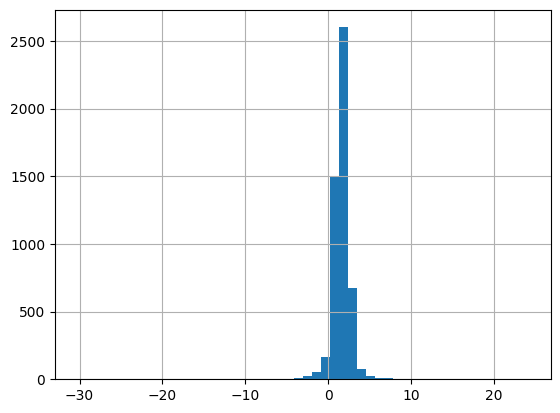

In [54]:
output_with_changes['SAE'].hist(bins = 50)

In [68]:
mask_red = output['b_scat_red'].mask(output['b_scat_red'] > 50)
mask_sae = output['SAE'].mask(output['SAE'] > 4)
mask_sae = mask_sae.mask(mask_sae < 0)

In [78]:
print(output['b_abs_blue'].describe([.25,.50,.75]))

count    15072.000000
mean        13.929688
std         10.005420
min        -31.321336
25%          7.768414
50%         13.060487
75%         18.147065
max         93.525636
Name: b_abs_blue, dtype: float64


In [77]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'SSA')

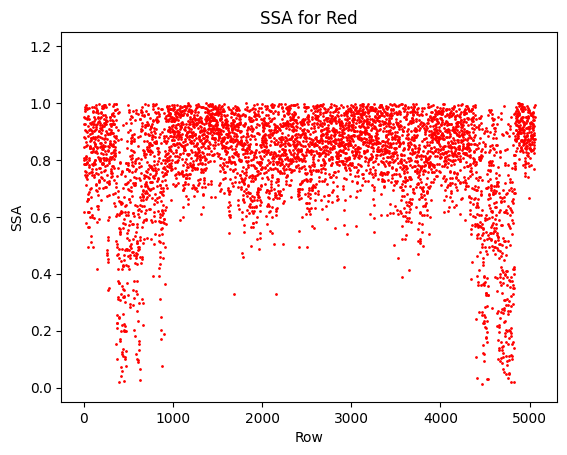

In [82]:
y_axis = df_final['SSA_red']
x_axis = list(range(len(optical_df_positive)))
#plt.scatter(x_axis, y_axis, s = 1)

plt.ylim(-0.05,1.25)
plt.scatter(x_axis, y_axis, s=1, c='r')
plt.title('SSA for Red')
plt.xlabel('Row')
plt.ylabel('SSA')


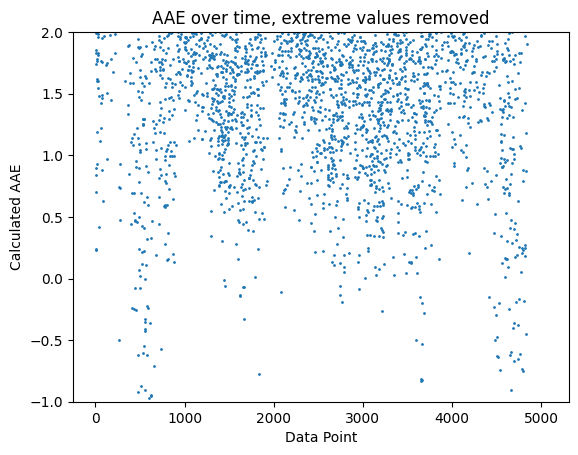

In [97]:
y_axis = output_with_changes['AAE']
x_axis = list(range(len(output_with_changes)))
#plt.scatter(x_axis, y_axis, s = 1)
#y_axis = mask_SSA['SSA']
plt.title('AAE over time, extreme values removed')
plt.xlabel('Data Point')
plt.ylabel('Calculated AAE')
plt.ylim(-1,2)
plt.scatter(x_axis, y_axis, s=1)

In [ ]:
y_axis = mask_sae
x_axis = list(range(len(mask_sae)))

plt.scatter(x_axis, y_axis, s = 1)
plt.title('SAE over time, extreme values removed')
plt.xlabel('Data Point')
plt.ylabel('Calculated SAE')
plt.show()

<AxesSubplot: >

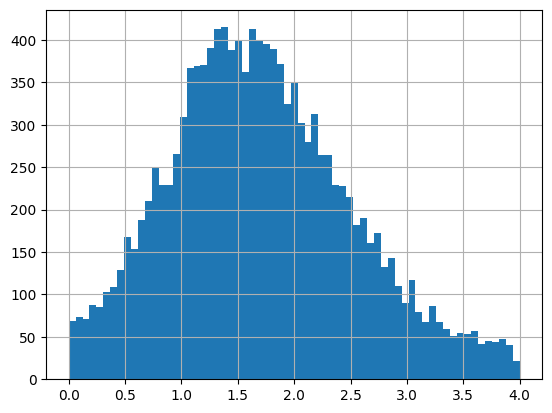

In [72]:
mask_sae.hist(bins=65)
#print(((output['b_scat_red'])>50).sum().sum())

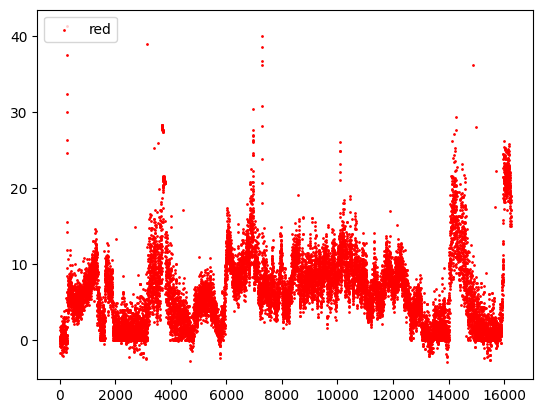

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1 = fig.add_subplot(111)

ax1.scatter(list(range(len(output))), mask_red, s=1, c='r', label='red')
#ax1.scatter(list(range(len(output))), output['b_scat_green'], s=1, c='g', label='green')
#ax1.scatter(list(range(len(output))), output['b_scat_blue'], s=1, c='b', label='blue')
plt.legend(loc='upper left')
plt.show()